In the previous [post](https://lucasvw.github.io/posts/14_mlp/) we went through a simple MLP language model. We looked in detail at embeddings, and how they can be used to overcome the *curse of dimensionality* encountered for n-gram based models.

In this post we are going to have a look at recurrent neural networks and how they are different from the MLP developed earlier. As we will see, the concept of an rnn is remarkably similar.

## Data

Everything starts with training data, for a description see the earlier [post](https://lucasvw.github.io/posts/13_ngram/)

In [ ]:
#| code-fold: true

import random
from functools import reduce, partial
from pathlib import Path
from urllib.request import urlretrieve
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torcheval.metrics as tem
import fastcore.all as fc

from nntrain.dataloaders import DataLoaders
from nntrain.learner import *
from nntrain.activations import *
from nntrain.acceleration import *
from nntrain.ngram import *

In [ ]:
########### Load the data ###########
path = Path('./data')
path.mkdir(parents=True, exist_ok=True)
path = path / 'names.txt'
url = 'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt'

_ = urlretrieve(url, path)

with open(path, 'r') as f:
    lines = f.read().splitlines()
    
random.seed(42)
random.shuffle(lines)

train_size=0.8
val_size=0.1

train_lines = lines[0:int(train_size * len(lines))]
val_lines = lines[int(train_size * len(lines)): int((train_size + val_size) * len(lines))]

### Create vocabulary and mappings ###
unique_chars = list(set("".join(lines)))
unique_chars.sort()
vocabulary = ['.'] + unique_chars

c2i = {c:i for i, c in enumerate(vocabulary)}
i2c = {i:c for i, c in enumerate(vocabulary)}

def get_dls(bs, context_length):
    train_ds = NgramDataset(train_lines, c2i, n=context_length+1)
    val_ds = NgramDataset(val_lines, c2i, n=context_length+1)
    train_loader = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=bs, num_workers=4)
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=bs*2, num_workers=4)
    dls = DataLoaders(train_loader, val_loader)
    return dls

## From MLP to RNN, a small change

The MLP model encountered in the last post, used an embedding layer to turn the tokens from the context (in the image below of length 3) into vectors. These vectors then got concatenated, and passed through a hidden layer. After that, the activations were mapped to the size of the vocabulary in the output layer:

![MLP architecture](arch.png){width=600}

For an RNN, we also start-off by turning our integers into vectors making use of an embedding layer. However, instead of concatenating the result and passing it through a hidden layer, we *iteratively feed the embedding activations through a single hidden layer*. Each time moving on to (the embedding activations of) the next token and adding the hidden activations obtained from the previous iteration. Once all the context has been processed in this way, we finalize with an output layer similar to what we did for the MLP model.

![RNN architecture](rnn.drawio.png){width=400}

:::{.callout-note}
The first time I learned about the summing of embedding activations and hidden activations, I was pretty surprised: how can you expect to get anything meaningful by simple adding activations from two layers together? As it turns out, in neural network literature it happens quite often that the combination / merging of activations simply happens by element-wise addition. In a section below, we will also shortly discuss another way of combining information: by concatenation. 
:::

Let's put this RNN architecture into code:

In [ ]:
class FixedContextRNN(nn.Module):
    
    def __init__(self, c2i, hidden_size=10):
        super().__init__()
        self.c2i = c2i
        self.input2hidden   = nn.Embedding(len(c2i), hidden_size)
        self.hidden2hidden  = nn.Linear(hidden_size, hidden_size)
        self.hidden2out     = nn.Linear(hidden_size, len(c2i))
        
    def forward(self, x):
        input1 = F.relu(self.input2hidden(x[:,0]))
        input2 = F.relu(self.input2hidden(x[:,1]))
        input3 = F.relu(self.input2hidden(x[:,2]))
        
        out = F.relu(self.hidden2hidden(input1))
        out = F.relu(self.hidden2hidden(out + input2))
        out = F.relu(self.hidden2hidden(out + input3))
        
        return self.hidden2out(out)

Observe that both the embedding dimension and the size of the hidden layer need to be equal (`hidden_size`) because the activations from both these layers are added together and thus need to be of equal shape. This also means that there is just one hyperparameter influencing the amount of parameters in this network.

We can generalize this model, so that it accepts data of arbitrary context length. Also, we will make use of a *dummy hidden-layer activation tensor* (initialized to zeros) so that we can do the addition for all iterations (and not just for the second iteration onward):

In [ ]:
class VariableContextRNN(nn.Module):
    
    def __init__(self, c2i, hidden_size):
        super().__init__()
        self.c2i = c2i
        self.hidden_size = hidden_size
        self.input2hidden   = nn.Embedding(len(c2i), hidden_size)
        self.hidden2hidden  = nn.Linear(hidden_size, hidden_size)
        self.hidden2out     = nn.Linear(hidden_size, len(c2i))
        
    def forward(self, x):
        inputs = self.input2hidden(x)           # [bs, context_length, hidden_size]

        # create dummy hidden-layer activations for the very first token 
        h = torch.zeros((x.shape[0], self.hidden_size)).to(device)
        
        for i in range(x.shape[1]):             # iterate through the tokens (context length)
            h = F.relu(self.hidden2hidden(h + inputs[:,i,:])) # [bs, hidden_size]
            
        return self.hidden2out(h)               # [bs, classes]

Let's see how this model performs with a similar configuration to the first MLP we build in the previous [post](https://lucasvw.github.io/posts/14_mlp/#using-embeddings-effectively) (context length of 3 and a hidden size of 50):

epoch,mode,loss
0,train,2.636
0,eval,2.300
1,train,2.271
1,eval,2.247
2,train,2.226
2,eval,2.214
3,train,2.195
3,eval,2.185
4,train,2.171
4,eval,2.178


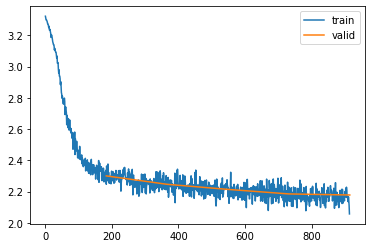

In [ ]:
# Train parameters
epochs = 5
lr     = 1e-2
bs     = 1000

# Hyperparameters
context_length = 3
n_h            = 50

dls = get_dls(bs, context_length)
rnn = VariableContextRNN(c2i, n_h)

subs = [ProgressS(True),
        MetricsS(),
        DeviceS(device)]

scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, epochs=epochs, steps_per_epoch=len(dls.train))

l = Learner(rnn, dls, F.cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)])
l.fit(epochs, lr=lr)

So it's doing a bit better (2.280 for the MLP, 2.178 for the RNN)

## Combing data: addition or concatenation

As mentioned, the first time I learned about the fact that we are simply adding activations from the hidden layer and the embedding layer, I was pretty surprised. Instead of simple addition of the activations we could also concatenate these activations instead. This means that our `hidden2hidden` layer shape needs to be updated:

In [ ]:
class VariableContextRNNConcat(nn.Module):
    
    def __init__(self, c2i, hidden_size):
        super().__init__()
        self.c2i = c2i
        self.hidden_size = hidden_size
        self.input2hidden   = nn.Embedding(len(c2i), hidden_size)
        self.hidden2hidden  = nn.Linear(2*hidden_size, hidden_size)
        self.hidden2out     = nn.Linear(hidden_size, len(c2i))
        
    def forward(self, x):
        inputs = self.input2hidden(x)                # [bs, context_length, hidden_size]
        
        h = torch.zeros((x.shape[0], self.hidden_size)).to(device)
        
        for i in range(x.shape[1]):
            h = torch.cat([h, inputs[:,i,:]], dim=1) # [bs, 2 x hidden_size]
            h = F.relu(self.hidden2hidden(h))        # [bs, hidden_size]
        
        return self.hidden2out(h)                    # [bs, classes]

epoch,mode,loss
0,train,2.595
0,eval,2.287
1,train,2.259
1,eval,2.234
2,train,2.217
2,eval,2.194
3,train,2.182
3,eval,2.173
4,train,2.157
4,eval,2.166


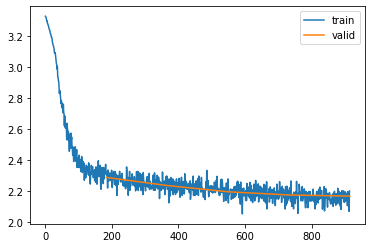

In [ ]:
rnn = VariableContextRNNConcat(c2i, n_h)

l = Learner(rnn, dls, F.cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)])
l.fit(epochs, lr=lr)

In this configuration, this seems to give a slightly better performance

## PyTorch RNN

Let's use PyTorch's `nn.RNN`, in the `PyTorchRNN` class defined below, we can see that this module replaces our `hidden2hidden` layer, and also takes care of the loop over the tokens in the context in our forward pass.

Some notes:

- `nn.RNN` uses a tanh activation by default, we can use a relu activation instead by setting the `nonlinearity` argument
- the (dummy) activations that we add for the processing of the first token need to have an additional empty dimension in first position (for the non bidirectional case) according to the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)
- when forwarding data through the rnn module, it expects the input data to have the context_length as first dimension. We can alter this by setting `batch_first=True`
- `nn.RNN` returns two parameters. The first parameter is a tensor containing the hidden activation from each iteration, the second parameter has the final hidden activation. For the moment we are only interested in the last hidden activations and pass it to the output layer but we will use the aggregated hidden activations in a section below

In [ ]:
class PyTorchRNN(nn.Module):
    
    def __init__(self, c2i, context_length, hidden_size):
        super().__init__()
        self.c2i = c2i
        self.hidden_size = hidden_size
        self.input2hidden   = nn.Embedding(len(c2i), hidden_size)
        self.rnn            = nn.RNN(hidden_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.hidden2out     = nn.Linear(hidden_size, len(c2i))
        
    def forward(self, x):
        inputs = self.input2hidden(x) # [bs, context_length, hidden_size]
        
        h = torch.zeros((1, x.shape[0], self.hidden_size)).to(device)
        
        hs, h = self.rnn(inputs, h)
        # hs : [bs, context_length, hidden_size] -> all hidden states
        # h  : [1, bs, hidden_size]              -> final hidden state

        return self.hidden2out(h.squeeze(0)) # squeeze out the first empty dimension

epoch,mode,loss
0,train,2.601
0,eval,2.285
1,train,2.261
1,eval,2.228
2,train,2.216
2,eval,2.195
3,train,2.182
3,eval,2.173
4,train,2.157
4,eval,2.163


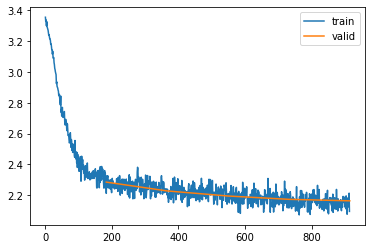

In [ ]:
rnn = PyTorchRNN(c2i, context_length, n_h)

l = Learner(rnn, dls, F.cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)])
l.fit(epochs, lr=lr)

## Optimizing dataloading and model for sequential data (BPTT)

Although the previous RNN's are perfectly valid models, there is a pretty big improvement we can make for the training of these models. To realize that, let's have a look at the samples for the first name *Yuheng* in our dataset:

In [ ]:
xb, yb = dls.train.dataset[0:6]
for x,y in zip(xb, yb):
    print(list(i2c[i.item()] for i in x), '-->' ,i2c[y.item()])

['.', '.', '.'] --> y
['.', '.', 'y'] --> u
['.', 'y', 'u'] --> h
['y', 'u', 'h'] --> e
['u', 'h', 'e'] --> n
['h', 'e', 'n'] --> g


Consider what happens when we process this data *in order* with a batch size of 1. In the very first batch (forward pass) we start with an empty hidden state and compute the final hidden state $h_0$ from processing the three `'.'` tokens sequentially. These final activations are mapped to output activations and the loss is computed by comparing to the label `'y'`.

When moving to the second batch we start again with an empty hidden state, and since we have moved one letter forward we will process 2 `'.'` tokens and the `'y` token sequentially to get to the final hidden activation $h_1$ of this sample. But this is a bit silly, we could have just remembered our hidden activations $h_0$ from the first batch and process the next token (`'y'`) to get to the same result!

In other words: for each forward pass, we reinitialize the dummy hidden layer activations, and the first two tokens we process are in fact already processed in the previous sample. We could be more efficient by just using the hidden activations we computed on the previous sample and have one iteration over the new token in the context:

![More efficient data-processing for sequential data](rnn2.drawio.png){width=600}

Let's simplify things and make the architecture symmetrical by not treating the very first sample in a different way. This also means we can get rid of the triple start symbol (`...`) and replace it with a single start symbol (`.`).

![Symmetric architecture for efficient data-processing](rnn3.drawio.png){width=600}

With these changes, there are two practical problems we need to address: 

1. How are we going to change the dataloader and dataset to feed this into a neural network? 
2. Feeding the hidden activations into the processing of the next token means that the computational graph of the loss is getting more and more complex. If we do this for the entirety of our dataset, the backward pass will become intractable. We thus have to cut it off at some point.

We need to go from samples (combinations of `X` and `y`) that look like this (and don't pass over the hidden state from sample to sample):

In [ ]:
#| code-fold: true
xb, yb = dls.train.dataset[0:7]
for x,y in zip(xb, yb):
    print(list(i2c[i.item()] for i in x), '-->' ,i2c[y.item()])

['.', '.', '.'] --> y
['.', '.', 'y'] --> u
['.', 'y', 'u'] --> h
['y', 'u', 'h'] --> e
['u', 'h', 'e'] --> n
['h', 'e', 'n'] --> g
['e', 'n', 'g'] --> .


to samples that simply look like this (and *do* pass the hidden state from sample to sample):

In [ ]:
#| code-fold: true
name = '.yuheng.'
for i in range(len(name)-1):
    print(f"['{name[i]}'] --> {name[i+1]}")

['.'] --> y
['y'] --> u
['u'] --> h
['h'] --> e
['e'] --> n
['n'] --> g
['g'] --> .


However, we want to keep the sequence length dimension since we will use that as the maximal amount of tokens through which we will backpropagate. This addresses the second issue mentioned above. We thus need a dataset that looks like this (for a sequence length of 3):

In [ ]:
#| code-fold: true
print("['.', 'y', 'u']", '-->', "['y', 'u', 'h']")
print("['h', 'e', 'n']", '-->', "['e', 'n', 'g']")

['.', 'y', 'u'] --> ['y', 'u', 'h']
['h', 'e', 'n'] --> ['e', 'n', 'g']


For the above example, we would still pass the hidden state computed in the first sample to the second sample, but only the values are passed and not the computational history. This is essentially what's referred to as (truncated) backpropagation through time. Also, note that this means that one single sample (`['.', 'y', 'u']`) will create 3 outputs (for the 3 labels `['y', 'u', 'h']`). This means we will have to update our loss function as well.

Let's create a new dataset for this purpose:

In [ ]:
class SequentialDataset():
    def __init__(self, lines, c2i, sequence_length):
        text = "." + ".".join(lines) + "."
        self.x = []
        self.y = []
        for i in range(0, len(text) - sequence_length - 1, sequence_length):
            self.x.append([c2i[xi] for xi in text[i: i+sequence_length]])
            self.y.append([c2i[yi] for yi in text[i+1: i+sequence_length+1]])
        self.x = torch.tensor(self.x)
        self.y = torch.tensor(self.y)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return len(self.x)
    
train_ds = SequentialDataset(train_lines, c2i, 3)
valid_ds = SequentialDataset(val_lines, c2i, 3)

In [ ]:
for i in range(2):
    print([i2c[xi.item()] for xi in train_ds[i][0]], '-->', [i2c[xi.item()] for xi in train_ds[i][1]])

['.', 'y', 'u'] --> ['y', 'u', 'h']
['h', 'e', 'n'] --> ['e', 'n', 'g']


Furthermore, we need to order our data in a different way. We need to be very careful with shuffling: we certainly can't shuffle individual samples anymore in our Dataloader, since we need to maintain the sequence of our data. 

:::{.callout-note}
We could however shuffle the order of the **complete** names, at the beginning of each epoch. But let's not be concerned with that for now, and just disable shuffling altogether.
:::

Also, we need to make sure that the stream *continues from sample to sample across batches*, so that we can pass the (final) hidden states from the samples in a batch to the samples in the next batch. Consider a dataset consisting of 100 sequential samples:

![](rnn5.drawio.png){width=600}

If we order the data in this way, only the very first batch of each epoch will be using a dummy hidden state equal to zero, all other iterations in all the batches will be using the correct (previously computed and sequentially passed) hidden state.

To get these batches into the model during training, we need to order the data *vertically*, so 1, 21, 41, 61, 81, 2, 22, 42, etc. Let's do so with a custom Sampler (for details on samplers, check out this earlier blog [post](https://lucasvw.github.io/posts/09_nntrain_ds/#next-up-shuffling-the-data)):

!["Vertical" sampling order](sampler_order.drawio.png)

In [ ]:
class VerticalSampler():
    def __init__(self, ds, batch_size):
        self.batch_size = batch_size
        self.batches = len(ds) // self.batch_size
        
    def __iter__(self):
        for i in range(self.batches):
            for j in range(self.batch_size):
                yield i + self.batches*j
                
    def __len__(self):
        return self.batches * self.batch_size

With this sampler we can then create a dataloader with the associated batch size to load exactly the batches into the model as described!

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds, shuffle=False, sampler=VerticalSampler(train_ds, bs), batch_size=bs)
valid_dl = torch.utils.data.DataLoader(valid_ds, shuffle=False, sampler=VerticalSampler(valid_ds, bs), batch_size=bs)

dls = DataLoaders(train_dl, valid_dl)

Now let's update our model to pass all the hidden states to the output layer:

In [ ]:
class PyTorchRNNMultiOutput(nn.Module):
    
    def __init__(self, c2i, hidden_size, bs):
        super().__init__()
        self.c2i = c2i
        self.bs = bs
        self.hidden_size = hidden_size
        self.register_buffer('h', torch.zeros((1, bs, self.hidden_size)))
        
        self.input2hidden   = nn.Embedding(len(c2i), hidden_size)
        self.rnn            = nn.RNN(hidden_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.hidden2out     = nn.Linear(hidden_size, len(c2i))
        
    def forward(self, x):
        inputs = self.input2hidden(x)
        hs, h = self.rnn(inputs, self.h)
        # hs : [bs, context_length, hidden_size]
        # h  : [1, bs, hidden_size]
        self.h = h.detach()
        return self.hidden2out(hs)

And finally, we have to create a custom loss function that can deal with the multiple output activations and multiple labels:

In [ ]:
def multi_output_cross_entropy(logits, targets):
    # logits = [bs, context_length, output_classes]
    # targets = [bs, context_length]
    
    targets = targets.view(-1)
    
    bs, context_length, output_classes = logits.shape
    logits = logits.view(-1, output_classes)
    
    return F.cross_entropy(logits, targets)

In [ ]:
def get_dls(context_length, batch_size):
    train_ds = SequentialDataset(train_lines, c2i, context_length)
    valid_ds = SequentialDataset(val_lines, c2i, context_length)
        
    train_dl = torch.utils.data.DataLoader(train_ds, shuffle=False, sampler=Sampler(train_ds, batch_size), batch_size=batch_size)
    valid_dl = torch.utils.data.DataLoader(valid_ds, shuffle=False, sampler=Sampler(valid_ds, batch_size), batch_size=batch_size)

    return DataLoaders(train_dl, valid_dl)

Note that we drop the batch size to a value of 300 (1/3 of 1000). We do this, to roughly keep the amount of weight updates per batch constant. Previously, we had 1000 sequences in the batch, and from each sequence we would receive one "weight update". Now, we have 3 times the amount of sequences in a batch, so we have to reduce the batch size by 3 to keep the amount of "weight updates" roughly equal.

epoch,mode,loss
0,train,2.518
0,eval,2.226
1,train,2.175
1,eval,2.164
2,train,2.115
2,eval,2.128
3,train,2.063
3,eval,2.101
4,train,2.024
4,eval,2.091


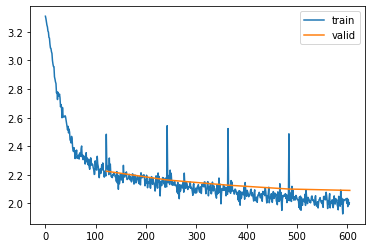

In [ ]:
# Train parameters
epochs = 5
lr     = 1e-2
bs     = 300

# Hyperparameters
context_length = 5
n_h            = 100

dls = get_dls(context_length, bs)
rnn = PyTorchRNNMultiOutput(c2i, n_h, bs)

subs = [ProgressS(True),
        MetricsS(),
        DeviceS(device)]

scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, epochs=epochs, steps_per_epoch=len(dls.train))

l = Learner(rnn, dls, multi_output_cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)])
l.fit(epochs, lr=lr)

Performance is pretty good, however what's up with the spikes in the loss? These spikes occur at the beginning of every epoch and they happen because moving from the last batch in an epoch, to the first batch in the next epoch is not a sequential step in the data. Looking at the image above in which we laid out the "vertical ordering of the data", wee see that for the first batch in any epoch > 1, we would feed the hidden state originating from samples (20, 40, 60, 80, 100) into the samples (1, 21, 41, 61, 81), e.g.:

In [ ]:
#| code-fold: true

frm = (20, 40, 60, 80, 100)
to  = (1, 21, 41, 61, 81)

for f, t in zip(frm,to):
    print(f'from: {f:3d} to: {t:2d}')

from:  20 to:  1
from:  40 to: 21
from:  60 to: 41
from:  80 to: 61
from: 100 to: 81


And this is obviously not sequential. The easiest solution is to reset the hidden state to zero at the beginning of each epoch, let's do this with a very small `Subscriber`:

:::{.callout-note}
Based on the observation that we could realign the hidden activations by moving them one row down, I implemented this solution but was surprised to see that this doesn't improve things at all. I then found that we generally don't have a fully connected sequential dataset that fits exactly into a whole number of batches, we thus lose some data in the end, and the data doesn't connect easily by shifting it "one row down". In terms of the sample ordering diagram above: we generally don't have (20, 40, 60, 80, 100) as final batch of an epoch but instead something like (18, 38, 58, 78, 98).
:::

In [ ]:
class HiddenStateResetterS(Subscriber):
    def before_epoch(self, learn):
        learn.model.reset_hidden_state()
        
@fc.patch
def reset_hidden_state(self:PyTorchRNNMultiOutput):
    device = self.h.get_device()
    self.h = torch.zeros_like(self.h).to(device)

epoch,mode,loss
0,train,2.520
0,eval,2.221
1,train,2.178
1,eval,2.158
2,train,2.113
2,eval,2.115
3,train,2.064
3,eval,2.080
4,train,2.025
4,eval,2.069


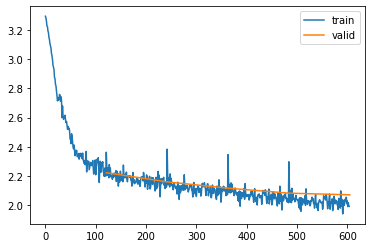

In [ ]:
# Train parameters
epochs = 5
lr     = 1e-2
bs     = 300

# Hyperparameters
context_length = 5
n_h            = 100

dls = get_dls(context_length, bs)
rnn = PyTorchRNNMultiOutput(c2i, context_length, n_h, bs)

subs = [ProgressS(True),
        MetricsS(),
        DeviceS(device),
        HiddenStateResetterS()]

scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, epochs=epochs, steps_per_epoch=len(dls.train))

l = Learner(rnn, dls, multi_output_cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)])
l.fit(epochs, lr=lr)

The loss improved a bit from this fix, and the spikes are smaller, but still visible. This is not surprising since the very first batch in each epoch still has the difficulty of working with an empty hidden state. This is not a big issue however, since the hidden state is quickly filling up. Accordingly, the following batches show again a loss that is in-line with the loss of the end of the previous epoch.

Last but not least, PyTorch `nn.RNN` accepts two parameters, one for the features in the inputs and one for the features in the hidden state. Previously we used one single parameter for this to make sure we can add the activations. Apparently, `nn.RNN` is doing another multiplication to align them. So let's use these two values as separate arguments to see whether we can further improve performance through tweaking them.

In [ ]:
class PyTorchRNNMultiOutput(nn.Module):
    
    def __init__(self, c2i, embedding_dim, hidden_size, bs):
        super().__init__()
        self.c2i = c2i
        self.bs = bs
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        # register as buffer so that its moved to the device by the DeviceS Subscriber
        self.register_buffer('h', torch.zeros((1, bs, self.hidden_size))) 
        
        self.input2hidden   = nn.Embedding(len(c2i), embedding_dim)
        self.rnn            = nn.RNN(embedding_dim, hidden_size, nonlinearity='relu', batch_first=True)
        self.hidden2out     = nn.Linear(hidden_size, len(c2i))
        
    def forward(self, x):
        inputs = self.input2hidden(x)
        hs, h = self.rnn(inputs, self.h)
        # hs : [bs, context_length, hidden_size]
        # h  : [1, bs, hidden_size]
        self.h = h.detach()
        return self.hidden2out(hs)
    
    def reset_hidden_state(self):
        device = self.h.get_device()
        self.h = torch.zeros_like(self.h).to(device)

Trying for around 10 minutes with different settings shows me that performance can be slightly improved by increasing the size of the hidden state by quite a bit, and keeping the embedding dimension smaller:

epoch,mode,loss
0,train,2.370
0,eval,2.180
1,train,2.133
1,eval,2.131
2,train,2.045
2,eval,2.056
3,train,1.928
3,eval,2.005
4,train,1.817
4,eval,1.986


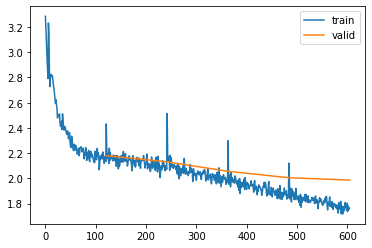

In [ ]:
# Train parameters
epochs = 5
lr     = 1e-2
bs     = 300

# Hyperparameters
context_length = 5
n_h            = 1000
embedding_dim  = 100

dls = get_dls(context_length, bs)
rnn = PyTorchRNNMultiOutput(c2i, embedding_dim, n_h, bs)

subs = [ProgressS(True),
        MetricsS(),
        DeviceS(device),
        HiddenStateResetterS()]

scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, epochs=epochs, steps_per_epoch=len(dls.train))

l = Learner(rnn, dls, multi_output_cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)])
l.fit(epochs, lr=lr)

## Sampling names

And as we did with the MLP, let's conclude with some sampled names from this model

In [ ]:
@fc.patch
def generate(self:PyTorchRNNMultiOutput, n=10, generator=None):
    # For unbatched input we need a 2D hidden state tensor of size [1, hidden_size]
    self.h = torch.zeros((1, self.hidden_size)).cuda()
    
    names = []
    for i in range(n):
        name = '.'
        while True:
            idx = torch.tensor([c2i[name[-1]]]).cuda()
            logits = self.forward(idx)
            s = torch.multinomial(F.softmax(logits, dim=1), 1, generator=generator)
            c = i2c[s.item()]
            name += c
            if c == '.':
                names.append(name)
                break
    return names

In [ ]:
rnn.generate()

['.elanora.',
 '.alaijah.',
 '.zabra.',
 '.diriyah.',
 '.juannabella.',
 '.kayahni.',
 '.ziak.',
 '.skydir.',
 '.braved.',
 '.robina.']

## Outlook

We have come quite a long way, and we have seen that an RNN is in essence not very different from the MLP created earlier. The complexity in my opinion only has to do with the different way of processing and loading the data, which greatly reduces the time to train such models. In the next post we are going to have a look at long short-term memory (LSTM) networks and gated recurrent unit networks (with lot's of fancy diagrams 😏).